In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, Dropout, SpatialDropout1D, MaxPooling1D, BatchNormalization, Activation

import gensim.downloader as api
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split

In [2]:
# Set constants

PATH = "data/"
# WORD2VEC_NAME = "word2vec-google-news-300"
WORD2VEC_NAME = "glove-twitter-50"
# NUM_FEATURES = 100
# NUM_WORDS = 5000

In [3]:
# Download Gensim data

word2vec = api.load(WORD2VEC_NAME)
# word2vec.save(PATH + WORD2VEC_NAME)

In [4]:
# Load Gensim data from disk

# word2vec = Word2Vec.load(PATH + WORD2VEC_NAME)

In [5]:
# Retrieve vocabulary from disk

print("Retrieving article data from disk...")
dataset = pd.read_csv(PATH + "dataset_clean.csv")
print(dataset)

Retrieving article data from disk...
                                          Article_Title  \
0     If anti-Sanders Democrats were serious, they’d...   
1     The Japanese prime minister is going to Pearl ...   
2     The best argument for each of the 2020 Democra...   
3     Instagram found a new place to show you ads: I...   
4                           My Week Without Apple Watch   
...                                                 ...   
6808  EpiPen Price Hikes Reportedly Added Millions T...   
6809  The First Year Home May Be Most Dangerous For ...   
6810  Mistakes That Fueled Ebola Spread Are Preventi...   
6811              Taylor Spear's GPS Guide On Self Care   
6812  Hacktivists Couldn't Have Pulled Off Cyber Att...   

                                           Article_Text         Publish_Date  \
0     democrats opposed to sen bernie sanders want y...  2020-02-29 20:00:00   
1     about six months ago president obama became th...  2016-12-27 14:20:01   
2     share al

In [6]:
USE_GENSIM = True
# NUM_WORDS = 20000
MAX_SEQ_LEN = 500
NUM_FEATURES = 50

train, test = train_test_split(dataset)
x_train = train.loc[:, "Article_Text"].values
y_train = train.loc[:, "Label"].values
x_test = test.loc[:, "Article_Text"].values
y_test = test.loc[:, "Label"].values

if USE_GENSIM:
    # max_length = max([len(x.split()) for x in x_train])
    max_length = MAX_SEQ_LEN
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x_train)
    sequences = tokenizer.texts_to_sequences(x_train)
    word_index = tokenizer.word_index
    x_train_pad = pad_sequences(sequences, maxlen=max_length)

    sequences_test = tokenizer.texts_to_sequences(x_test)
    x_test_pad = pad_sequences(sequences_test, maxlen=max_length)

    indices = np.arange(x_train_pad.shape[0])
    np.random.shuffle(indices)
    x_train_pad = x_train_pad[indices]
    y_train = y_train[indices]

    num_words = len(word_index) + 1
    # num_words = NUM_WORDS
    embedding_matrix = np.zeros((num_words, NUM_FEATURES))
    for word, i in word_index.items():
        if i > num_words or not word in word2vec.vocab:
            continue
        embedding_vector = word2vec[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
else:
    # Tokenize data
    print("Tokenizing data...")
    tokenizer = Tokenizer(num_words=NUM_WORDS)
    total_x = np.concatenate((x_train, x_test))
    tokenizer.fit_on_texts(total_x)
    # print(tokenizer.word_index)

    # Getting some hyperparameters
    print("Getting hyperparameters (max_length and vocab_size)...")
#     max_length = max([len(x.split()) for x in total_x])
    max_length = MAX_SEQ_LENGTH
#     vocab_size = len(tokenizer.word_index) + 1
    print("\t", "max_length", MAX_SEQ_LEN)
    print("\t", "vocab_size", NUM_WORDS)

    # Convert data to sequences
    print("Converting data to sequences...")
    x_train_tokens = tokenizer.texts_to_sequences(x_train)
    x_test_tokens = tokenizer.texts_to_sequences(x_test)
    print("\t", "x_train_tokens length", len(x_train_tokens))
    print("\t", "x_test_tokens length", len(x_test_tokens))

    # Pad sequences
    print("Padding sequences...")
    x_train_pad = pad_sequences(x_train_tokens, maxlen=max_length)
    x_test_pad = pad_sequences(x_test_tokens, maxlen=max_length)
    print("\t", "x_train_pad shape", x_train_pad.shape)
    print("\t", "x_test_pad shape", x_test_pad.shape)
    print("Done!")

In [13]:
# Build and train the model

# Set constants
BATCH_SIZE = 32
NUM_EPOCHS = 50
VALIDATION_STEPS = 10

# Batch and prefetch the dataset
tf_dataset = tf.data.Dataset.from_tensor_slices((x_train_pad, y_train))
tf_dataset = tf_dataset.batch(BATCH_SIZE)
tf_dataset = tf_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Build the model
print("Building the model...")
model = Sequential()
if USE_GENSIM:
    model.add(Embedding(num_words,
                        NUM_FEATURES,
                        weights=[embedding_matrix],
                        input_length=max_length,
                        trainable=False))
else:
    model.add(Embedding(NUM_WORDS, NUM_FEATURES, input_length=x_train_pad.shape[1]))   
    model.add(SpatialDropout1D(0.3))
# model.add(Conv1D(128, 3, padding='valid', activation='relu'))
# model.add(MaxPooling1D(pool_size=4))
# model.add(Dropout(0.5))
model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary(), "\n")

# Train the model
print("Training the model...")
history = model.fit(tf_dataset,
                    epochs=NUM_EPOCHS,
                    validation_data=(x_test_pad, y_test),
                    validation_steps=VALIDATION_STEPS)
# history = model.fit(x_train_pad, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(x_test_pad, y_test))
print("Done")

Building the model...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 50)           5181550   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               91648     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 5,273,327
Trainable params: 91,777
Non-trainable params: 5,181,550
_________________________________________________________________
None 

Training the model...
Train for 160 steps, validate on 1704 samples
Epoch 1/50
160/160 [==============================] - 201s 1s/step - loss: 0.4443 - accuracy: 0.7630 - val_loss: 0.3275 - val_accuracy: 0.8339
Epoch 2/50
160/160 [==============================] - 193s 1s/step - loss: 0.3546 - accuracy: 0.8229 - val_loss: 0.3038 - val_acc

Final Training Accuracy: 94.21%
Final Validation Accuracy: 92.66%


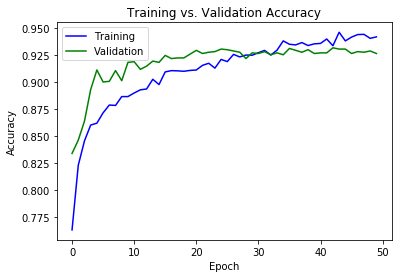

In [14]:
  # Graph the model history

print("Final Training Accuracy:", str(round(history.history['accuracy'][-1] * 100, 2)) + "%")
print("Final Validation Accuracy:", str(round(history.history['val_accuracy'][-1] * 100, 2)) + "%")
plt.plot(history.history['accuracy'], color='blue')
plt.plot(history.history['val_accuracy'], color='green')
plt.title('Training vs. Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

Final Training Loss: 13.23%
Final Validation Loss: 15.87%
Final Training Loss: 13.23%
Final Validation Loss: 15.87%


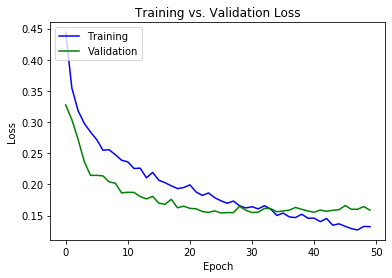

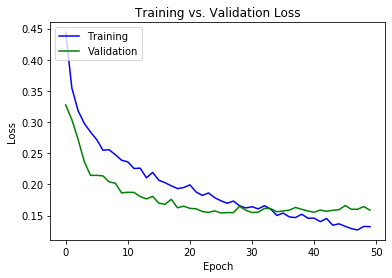

In [21]:
print("Final Training Loss:", str(round(history.history['loss'][-1] * 100, 2)) + "%")
print("Final Validation Loss:", str(round(history.history['val_loss'][-1] * 100, 2)) + "%")
plt.plot(history.history['loss'], color='blue')
plt.plot(history.history['val_loss'], color='green')
plt.title('Training vs. Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

In [15]:
# Evaluate the model

score, acc = model.evaluate(x_test_pad, y_test, batch_size=BATCH_SIZE)
print('Test score:', score)
print('Test accuracy:', acc)

1704/1704 [==============================] - 11s 7ms/sample - loss: 0.1587 - accuracy: 0.9266
Test score: 0.15873657898024215
Test accuracy: 0.9266432
